# Smart Cities Workshop 2017: Exploring NYC Buildings with Python

In [2]:


### path to MODA module
import sys
sys.path.append('code/')

## Open source tools
import pandas as pd
import matplotlib
import seaborn
import folium

## some functions MODA wrote to help automate simple tasks like geocoding
from MODA import GeoHelper


## enabling charts 
%matplotlib inline
matplotlib.style.use('seaborn-talk')


#### Preprocessing of PLUTO data I've already done to save time


## Surprisingly Difficult Question: What is a building?

**What aspects define a building?**  
* Structure? (4 walls, a door)?  
* Land it sits on?   
* What if I add an addition?  
* What if I build a new building on top of an [existing one](http://newyorkyimby.com/2016/01/developer-of-711-west-end-avenue-promises-new-amenities-for-rent-stabilized-tenants.html) ?


**To a person, these questions seem obvious or even silly. For data, they are challenging and important to answer when doing analysis.**

* NYC Dept. of Buildings Data [BIS](http://a810-bisweb.nyc.gov/bisweb/bispi00.jsp)
* NYC Dept. of Finance Data [ACRIS](http://a836-acris.nyc.gov/CP/)
* NYC Dept. of City Planning Data [(PLUTO)](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page) 



## What is PLUTO?

Primary Land Use Tax Lot Output (PLUTO!) is published by the Department of City Planning. PLUTO is a record of every lot of land in the city. 

See the Data Dictionary [here](https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/pluto_datadictionary.pdf?r=16v2)

**Why does the city care to know so much about what's on a lot of land?**




In [3]:
##I've done one bit of prep work that combined all five borough files into a single table.
PLUTO = pd.read_csv('PLUTO_processed.csv')

PLUTO.head()

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (20,21,23,24,25,26,27,65,66,81) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,Unnamed: 0.1,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,...,Sanborn,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,Version,BUILDING_CAT,BUILDING_CATCODE,BUILDING_CLASS
0,0,1,BK,1,50,302,21.0,2000.0,13.0,33.0,...,302 007,30101.0,E-231,0.0,NaN,1,16V2,E,E,WAREHOUSES
1,1,17,BK,7,21,302,21.0,2008.0,13.0,33.0,...,302 006,30101.0,NaN,0.0,NaN,1,16V2,G,G,GARAGES
2,2,20,BK,16,5,302,21.0,1001.0,13.0,33.0,...,302 006,30101.0,NaN,0.0,NaN,1,16V2,Q,Q,OUTDOOR RECREATION FACILITIES
3,3,21,BK,16,17,302,21.0,1001.0,13.0,33.0,...,302 006,30101.0,NaN,0.0,NaN,1,16V2,Q,Q,OUTDOOR RECREATION FACILITIES
4,4,22,BK,18,1,302,21.0,2002.0,13.0,33.0,...,302 006,30101.0,E-231,0.0,NaN,1,16V2,D,D,ELEVATOR APARTMENTS



## A warm up trivia question: What is the oldest building in NYC? 

[Spoiler](https://en.wikipedia.org/wiki/John_Bowne_House)

In [4]:
## Several buildings have year built '0' so I have to ignore those
PLUTO = PLUTO[PLUTO.YearBuilt >= 1000]


print 'The oldest building in PLUTO was built in ' + str(PLUTO.YearBuilt.min()) 

print 'The address is ' + PLUTO[PLUTO.YearBuilt == PLUTO.YearBuilt.min()].Address

The oldest building in PLUTO was built in 1661
503202    The address is 37-01 BOWNE STREET
Name: Address, dtype: object


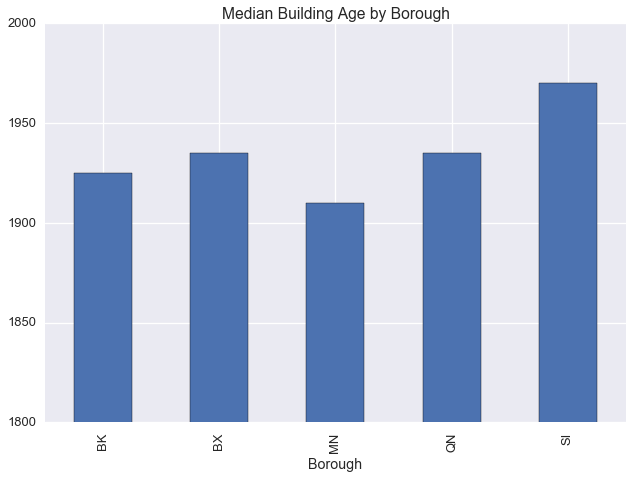

In [5]:
age = PLUTO.groupby('Borough')['YearBuilt'].median().plot(kind = 'bar', title = 'Median Building Age by Borough')
age = age.set_ylim(1800,2000)

## What kind of buildings are there? And how many?

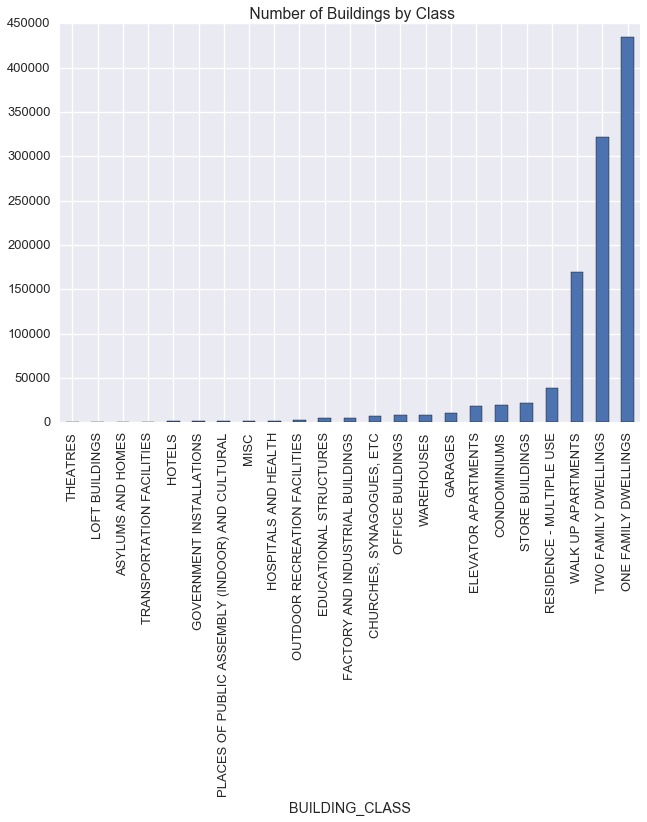

In [6]:
PLUTO.groupby('BUILDING_CLASS')['NumBldgs'].sum()\
            .sort_values()\
            .plot(kind = 'bar', title = ' Number of Buildings by Class')

## Which buildings are oldest? youngest?

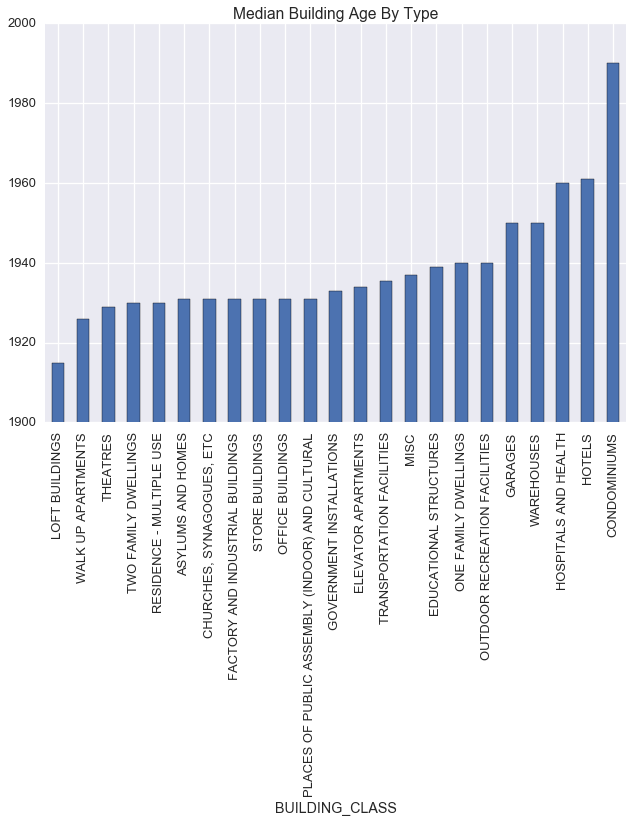

In [7]:
age = PLUTO.groupby('BUILDING_CLASS')['YearBuilt'].median()\
                        .sort_values()\
                        .plot(kind = 'bar', title = 'Median Building Age By Type')

age = age.set_ylim(1900,2000)

## A real-world example: Broadband Internet Access

MODA and the CTO's office collaborated to study the state of internet access for New Yorkers:

* [Many New Yorkers cannot afford broadband internet today](https://moda-nyc.carto.com/viz/1234cd1a-1fb0-11e7-ab3c-0e05a8b3e3d7/public_map)

* [Public Wifi is still sparsely accessibly outside of Manhatten](https://moda-nyc.carto.com/viz/abb9af18-3028-11e7-8700-0e3ff518bd15/public_map)

### How smart can a city be if it's citizens cannot afford reliable, broadband internet access?

* Many options to expand affordable and fast internet to all New Yorkers. Can you think of a few?



### One idea: A wireless network can be extended over relatively large distances 

Tall buildings with relatively unimpeded lines of sight are good candidates for a wireless repeater network. Some community groups are already implementing technology like this: [see here.](https://nycmesh.net/) 

*What if it were possible to use existing city resources as wireless repeater locations?*


In [8]:
## 'C' is a code for city-owned property
City_Owned = PLUTO[PLUTO.OwnerType == 'C'] 

## This finds the tallest city-owned building (by number of floors) in each Zip Code
Tallest_Facilities = City_Owned.ix[City_Owned.groupby('ZipCode').NumFloors.idxmax()]


Tallest_Facilities[['ZipCode', 'Address', 'OwnerName','NumFloors']]

,ZipCode,Address,OwnerName,NumFloors
359929,10001.0,340 8 AVENUE,DCAS/DEPARTMENT OF ED,10.00
350289,10002.0,227 MADISON STREET,HEALTH AND HOSPITALS,14.00
361920,10003.0,38 IRVING PLACE,DCAS/DEPARTMENT OF ED,9.00
348512,10004.0,44 BEAVER STREET,SANITATION,12.00
350247,10005.0,42 SOUTH STREET,NYC PARKS,2.00
348450,10006.0,25 WEST STREET,MTA BRIDGES & TUNNELS,8.00
348903,10007.0,1 CENTRE STREET,NYC DCAS,39.00
351389,10009.0,282 EAST 3 STREET,NYC DHS,6.00
363704,10010.0,25-00 F D R DRIVE,WATERSIDE PLAZA LP,40.00
359875,10011.0,233 WEST 24 STREET,DCAS/DEPARTMENT OF ED,11.00


## What kinds of buildings are both city-owned and relatively tall?

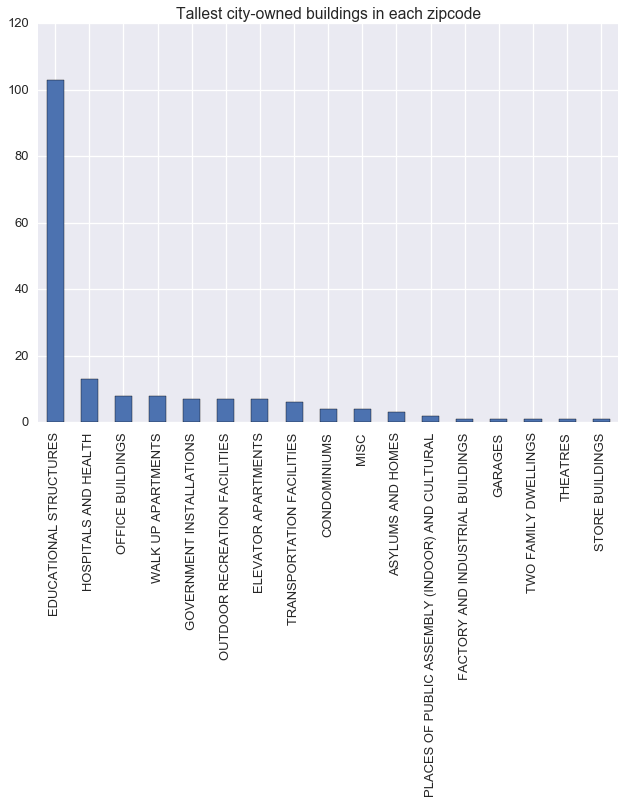

In [9]:
Tallest_Facilities.BUILDING_CLASS.value_counts().plot(kind = 'bar', title = 'Tallest city-owned buildings in each zipcode')

### We can also map all the buildings we found with folium 

(we just have to geocode them first)

In [10]:
%store

geoID = 'fb9ad04a'
geoKey = '051f93e4125df4bae4f7c57517e62344'

### NYC DOITT provides a free service to get latitude and longitude for any building in the city. 
f = GeoHelper(geoID,geoKey)
Tallest_Facilities = f.GetLatLong(Tallest_Facilities)

Stored variables and their in-db values:
found ID column: BBL


In [11]:
my_map = folium.Map(location=[40.7128 , -74.0059],tiles='Stamen Toner')

Tallest_Facilities.apply(lambda x: folium.Marker(location = [x['Latitude'], x['Longitude']]\
                                                 ,popup  = x['Address'] + ": Type; " + x['BUILDING_CLASS']).add_to(my_map) , axis = 1)

my_map

# Conclusion

* Hopefully this was fun & informative
* How can data like PLUTO help you make better decisions in your field? 
* What kind of questions can PLUTO **NOT** answer?
* What challenges do you face when trying to use data analytics in your field?
    * finding the right data?    
    * accessing data?  
    * unreliable data?  
    * finding the right tool?
    * asking the right questions?
    * something else?
    
    